In [13]:
# =============== 第一部分：训练V网络 ===============
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import matplotlib.pyplot as plt  

# ---------------------------
# 定义 V 网络
# ---------------------------
class PotentialNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.correction_net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        self.C1 = nn.Parameter(torch.tensor(1.0))
        self.C2 = nn.Parameter(torch.tensor(1.0))
        
    def forward(self, z):
        base = self.C1 / (z**2 + 1e-8) + self.C2 * z**2
        correction = self.correction_net(z)
        return base + correction

# ---------------------------
# 量子系统参数
# ---------------------------
delta1 = 0.1
delta_max = 20.0
N = 500
z = torch.linspace(delta1, delta_max, N).unsqueeze(-1)
h = (delta_max - delta1) / (N - 1)

# 目标本征能量平方根（波数）
targets = torch.tensor([1.475, 2.775], dtype=torch.float32)

# ---------------------------
# 构造哈密顿量
# ---------------------------
def assemble_hamiltonian(v):
    v_inner = v[1:-1].squeeze()
    diagonal = 2 / h**2 + v_inner
    off_diag = -1 / h**2 * torch.ones_like(v_inner[:-1])
    H = torch.diag(diagonal) + torch.diag(off_diag, 1) + torch.diag(off_diag, -1)
    return H

# ---------------------------
# 损失函数
# ---------------------------
def compute_loss(model):
    v = model(z)
    H = assemble_hamiltonian(v)
    eigenvalues = torch.linalg.eigh(H, UPLO='L').eigenvalues[:2]
    sqrt_eigenvalues = torch.sqrt(eigenvalues)
    return torch.mean((sqrt_eigenvalues - targets) ** 2)

# ---------------------------
# 训练
# ---------------------------
model = PotentialNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.005)

early_stop_threshold = 1e-7
for epoch in range(1000):
    optimizer.zero_grad()
    loss = compute_loss(model)
    loss.backward()
    optimizer.step()
    
    # 每 100 次打印一次
    if epoch % 100 == 0:
        with torch.no_grad():
            eigenvalues = torch.linalg.eigh(assemble_hamiltonian(model(z)), UPLO='L').eigenvalues[:2]
            sqrt_eigs = torch.sqrt(eigenvalues)
            print(f"Epoch {epoch:4d} | Loss: {loss.item():.6f} | Predicted: {sqrt_eigs.numpy().round(4)}")
    
    # 早停条件
    if loss.item() < early_stop_threshold:
        with torch.no_grad():
            eigenvalues = torch.linalg.eigh(assemble_hamiltonian(model(z)), UPLO='L').eigenvalues[:2]
            sqrt_eigs = torch.sqrt(eigenvalues)
            print(f"Early stopping at epoch {epoch} | Loss: {loss.item():.6f}")
            print(f"Eigenvalue sqrt predictions: {sqrt_eigs.numpy().round(6)}")
        break

# ---------------------------
# 保存模型
# ---------------------------
torch.save(model.state_dict(), 'pretrained_v.pth')
print("Model saved to pretrained_v.pth")


Epoch    0 | Loss: 0.157180 | Predicted: [1.8471 2.7227]
Early stopping at epoch 97 | Loss: 0.000000
Eigenvalue sqrt predictions: [1.473345 2.774644]
Model saved to pretrained_v.pth


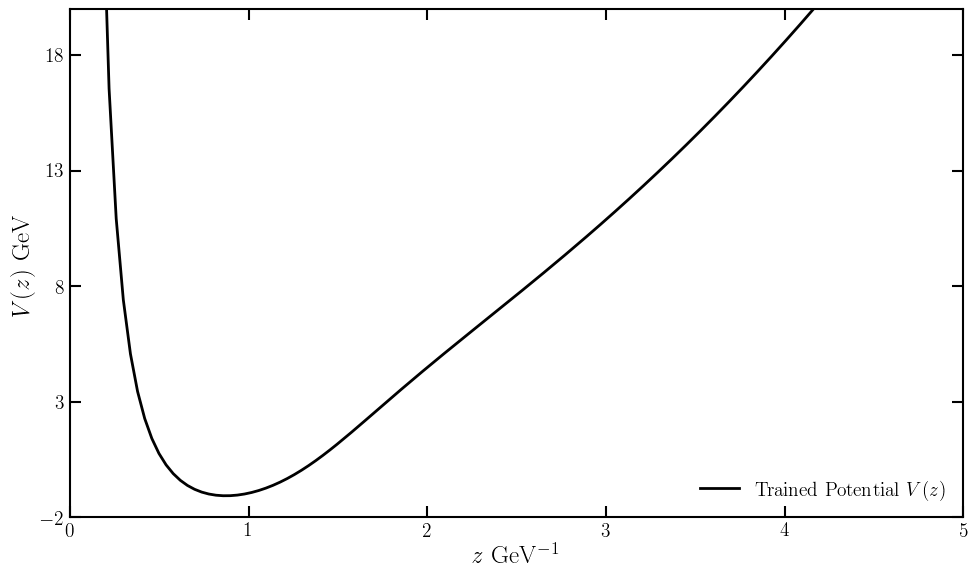

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 模型加载和推理部分 
model = PotentialNetwork()
model.load_state_dict(torch.load('pretrained_v.pth'))
model.eval()

with torch.no_grad():
    z_values = z.squeeze().numpy()
    v_values = model(z).squeeze().numpy()

# 图形设置部分 
plt.figure(figsize=(10, 6))
plt.plot(z_values, v_values, label='Trained Potential $V(z)$', color='black', linewidth=2)
plt.xlabel(r'$\mathit{z}$ $\rm GeV^{-1}$', fontsize=18)
plt.ylabel(r'$\mathit{V(z)}$ GeV', fontsize=18)
plt.legend(fontsize=14, frameon=False)
plt.xlim(0, 5)
plt.ylim(-2, 20)
plt.yticks(ticks=np.arange(-2, 21, 5), fontsize=14)

# 设置坐标轴和边框样式
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.xticks(fontsize=14)
plt.tick_params(axis='both', which='major', 
               direction='in',
               length=8, 
               width=1.5,
               bottom=True, top=True, left=True, right=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=14)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# 保存EPS格式
plt.tight_layout()
plt.savefig('potential_plot.eps', format='eps', dpi=1000)  
plt.show()  

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import matplotlib.pyplot as plt
import torch.nn.functional as F
import copy

# =============== 第一部分：定义V网络和BP网络结构 ===============
class BP_Network(nn.Module):
    def __init__(self, epsilon=1e-6):
        super().__init__()
        self.epsilon = epsilon
        
        # 增强隐藏层结构
        self.hidden = nn.Sequential(
            nn.Linear(1, 128),
            nn.SiLU(),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, 1)
        )

    def forward(self, z):
        raw_output = self.hidden(z)
        # 使用绝对值确保正数，取反后保证输出恒为负数
        positive_output = torch.abs(raw_output) + self.epsilon
        return -positive_output

# =============== 第二部分：参数设置和模型加载 ===============
delta1 = 0.01    
delta_max = 20.0
N = 500

# 加载预训练的V网络
model_v = PotentialNetwork()
model_v.load_state_dict(torch.load('pretrained_v.pth'))
model_v.eval()

# =============== 第三部分：训练BP网络 ===============
# 初始化BP网络和优化器
bp_net = BP_Network()
optimizer = optim.AdamW(bp_net.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

# 创建z数据集
z = torch.linspace(delta1, delta_max, N).unsqueeze(-1)

# 训练状态跟踪
best_loss = float('inf')
best_model_state = None

# 训练循环
max_epoch = 12000
for epoch in range(max_epoch):
    optimizer.zero_grad()
    
    # 前向计算
    z_in = z.clone().requires_grad_(True)
    bp = bp_net(z_in)
    bp_deriv = grad(
        outputs=bp, 
        inputs=z_in,
        grad_outputs=torch.ones_like(bp),
        create_graph=True
    )[0]
    
    # 计算预测势能
    v_pred = bp_deriv/2 + (bp**2)/4
    
    # 获取目标势能
    with torch.no_grad():
        v_target = model_v(z_in)
    
    # 损失计算
    loss = torch.mean((v_pred - v_target)**2)  
    
    # 反向传播
    loss.backward()
    optimizer.step()
    scheduler.step()
    torch.nn.utils.clip_grad_norm_(bp_net.parameters(), max_norm=1.0)
    
    # 更新最佳模型
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_model_state = copy.deepcopy(bp_net.state_dict())
    
    # 打印训练信息
    if epoch % 2000 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.6f} | LR: {current_lr:.6f}")

# 加载最佳模型
bp_net.load_state_dict(best_model_state)
print(f"Best model achieved loss: {best_loss:.6f}")

Epoch    0 | Loss: 222951.093750 | LR: 0.010000
Epoch 2000 | Loss: 29.773504 | LR: 0.008100
Epoch 4000 | Loss: 0.055116 | LR: 0.006561
Epoch 6000 | Loss: 0.023715 | LR: 0.005314
Epoch 8000 | Loss: 0.011395 | LR: 0.004305
Epoch 10000 | Loss: 0.005091 | LR: 0.003487
Best model achieved loss: 0.003525


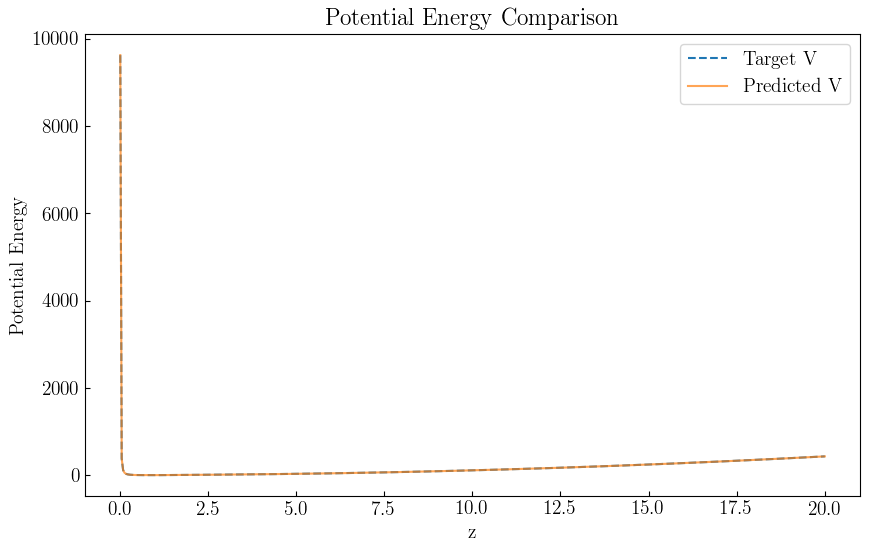

In [8]:
v_min = 0.1  
v_max = 20.0 
# =============== 第四部分：结果可视化和保存 ===============
# 创建需要梯度追踪的输入
z_vis = torch.linspace(delta1, delta_max, N).unsqueeze(-1).requires_grad_(True)

# 前向传播
bp = bp_net(z_vis)

# 计算一阶导数
bp_deriv = grad(outputs=bp, 
                inputs=z_vis,
                grad_outputs=torch.ones_like(bp),
                create_graph=False,
                retain_graph=False)[0]

# 安全分离计算图并转换数据
with torch.no_grad():
    # 分离张量并转换为numpy
    z_np = z_vis.detach().squeeze().numpy()
    bp_np = bp.detach().squeeze().numpy()
    bp_deriv_np = bp_deriv.detach().squeeze().numpy()
    
    # 计算预测势能
    v_pred = (bp_deriv_np / 2) + (bp_np**2) / 4
    v_pred_orig = (v_pred - v_min) / (v_max - v_min) * (v_max - v_min) + v_min
    
    # 获取目标势能
    v_target = model_v(z_vis.detach()).squeeze().numpy()
    v_target_orig = (v_target - v_min) / (v_max - v_min) * (v_max - v_min) + v_min

# 绘制势能对比图
plt.figure(figsize=(10, 6))
plt.plot(z_np, v_target_orig, label='Target V', linestyle='--')
plt.plot(z_np, v_pred_orig, label='Predicted V', alpha=0.7)
plt.xlabel('z')
plt.ylabel('Potential Energy')
plt.title('Potential Energy Comparison')
plt.legend()

# 保存最佳模型
torch.save(best_model_state, 'best_bp_network.pth')

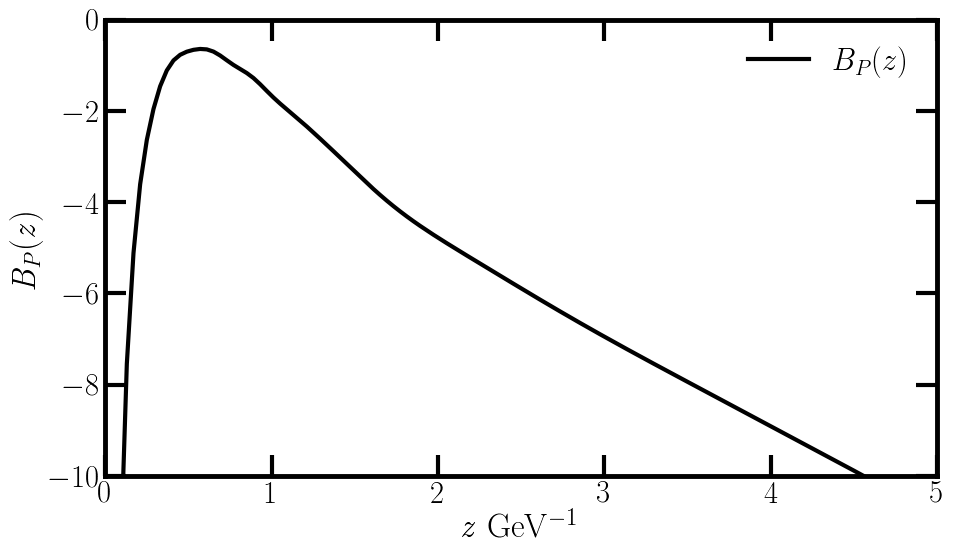

In [19]:
import matplotlib.pyplot as plt

# 第一步：设置全局字体为粗体
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22, weight='bold')  

plt.figure(figsize=(10, 6))

# 绘制曲线 - 进一步加粗
plt.plot(z_np, bp_np, color='black', linewidth=3.0, label='$B_P(z)$')  

# 设置坐标轴标签和图例
plt.xlabel(r'$\mathit{z}$ $\rm GeV^{-1}$', fontsize=24, fontweight='bold')  
plt.ylabel(r'$\mathit{B_P(z)}$', fontsize=24, fontweight='bold')  
plt.legend(fontsize=18, frameon=False, prop={'weight': 'bold'})  

# 设置坐标轴范围
plt.xlim(0, 5)
plt.ylim(-10, 0)

# 设置刻度样式和坐标轴边框
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# 确保刻度标签为粗体
plt.xticks(fontsize=22, fontweight='bold')  
plt.yticks(fontsize=22, fontweight='bold') 

# 设置刻度参数 - 确保刻度线本身粗重
plt.tick_params(axis='both', which='major', 
               direction='in',
               length=15,  
               width=3.0, 
               bottom=True, top=True, left=True, right=True)

# 设置边框线宽 - 进一步加粗边框
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(3.5)  

plt.tight_layout()

# 保存为EPS格式（在plt.show()之前）
plt.savefig('bp_plot.eps', format='eps', dpi=1000)  
plt.show()

In [12]:
import torch
import torch.nn as nn
from torch.autograd import grad
from torch.nn import functional as F

class A_Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(1, 64),
            nn.Linear(64, 64),
            nn.Linear(64, 64),
            nn.Linear(64, 1)
        ])
        # 强制所有权重为正
        for layer in self.layers:
            layer.weight.data = torch.abs(layer.weight.data)
            if layer.bias is not None:
                layer.bias.data.uniform_(-0.1, 0.1)

    def forward(self, z):
        x = z
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x)) 
        return -torch.exp(self.layers[-1](x)) 


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 初始化并加载预训练的 model_AA
class ModelAA(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Sigmoid(),
            nn.Linear(64, 128),
            nn.Sigmoid(),
            nn.Linear(128, 64),
            nn.Sigmoid(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # 输出范围[0, 1]
        )
        
    def forward(self, x):
        # 将输出缩放到[-10, 0]，再乘以x确保x=0时输出为0
        scaled_output = -10 * self.net(x)  # 强制输出为负
        return x * scaled_output

model_AA = ModelAA().to(device)
checkpoint = torch.load('model_AA_best_checkpoint.pth', map_location=device)
model_AA.load_state_dict(checkpoint['model_state'])
model_AA.eval()


model_A = A_Network().to(device)
model_BP = BP_Network().to(device)
model_BP.load_state_dict(torch.load('best_bp_network.pth'))
model_BP.eval()

# 初始化优化器和调度器
optimizer = torch.optim.Adam(model_A.parameters(), lr=0.01, weight_decay=1e-4)
# 使用StepLR，每隔100个epoch学习率乘以0.96
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.96)

def compute_loss(z_batch):
    mask_01_2 = (z_batch >= 0.01) & (z_batch < 2)
    mask_2_20 = (z_batch >= 4) & (z_batch <= 20.0)
    
    z_01_2 = z_batch[mask_01_2.squeeze()]
    z_2_20 = z_batch[mask_2_20.squeeze()]
    
    total_loss = 0.0
    loss_components = {'low': 0.0, 'high': 0.0}
    
    if z_01_2.numel() > 0:
        z = z_01_2.detach().requires_grad_(False)
        A_pred = model_A(z)
        # 使用 model_AA 生成目标
        with torch.no_grad():
            target = model_AA(z)
        loss_low = torch.mean((A_pred - target) ** 2) *50
        total_loss += loss_low
        loss_components['low'] = loss_low.item()
    
    if z_2_20.numel() > 0:
        z = z_2_20.requires_grad_(True)
        A = model_A(z)
        
        A_prime = grad(A, z, grad_outputs=torch.ones_like(A), 
                      create_graph=True, retain_graph=True)[0]
        
        A_double_prime = grad(A_prime, z, grad_outputs=torch.ones_like(A_prime),
                            create_graph=True)[0]
        
        phi_prime = torch.sqrt(torch.relu(6*(-A_double_prime + A_prime**2 - 2*A_prime/z)) + 1e-6)
        sqrt_1_6 = torch.sqrt(torch.tensor(1/6, device=device))
        AS_prime = A_prime + sqrt_1_6 * phi_prime - 1.0/z
        
        BP_output = 3*AS_prime - phi_prime
        with torch.no_grad():
            BP_target = model_BP(z)
        
        loss_high = torch.mean((BP_output - BP_target) ** 2)
        total_loss += loss_high
        loss_components['high'] = loss_high.item()
    
    return total_loss, loss_components

# 训练参数调整
num_epochs = 60000
batch_size = 256

best_loss = float('inf')

for epoch in range(num_epochs):
    # 动态采样策略：初期侧重0.1-2区间（60%），后期平衡
    base_ratio = 0.6  # 初始60%样本来自0.1-2区间
    min_ratio = 0.4   # 后期最低保持40%
    ratio = max(min_ratio, base_ratio - epoch/num_epochs*0.2)
    
    n_low = int(batch_size * ratio)
    n_high = batch_size - n_low
    
    # 修改采样范围
    z_01_2_samples = torch.FloatTensor(n_low, 1).uniform_(0.1, 2).to(device)
    z_2_20_samples = torch.FloatTensor(n_high, 1).uniform_(4, 20.0).to(device)
    z_batch = torch.cat([z_01_2_samples, z_2_20_samples])
    
    optimizer.zero_grad()
    loss, components = compute_loss(z_batch)
    loss.backward()
    
    nn.utils.clip_grad_norm_(model_A.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

    # 强制权重非负
    with torch.no_grad():
        for layer in model_A.layers:
            layer.weight.data.clamp_(min=0)

    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model_A.state_dict(), 'best_A_network.pth')
    
    if epoch % 5000 == 0:
        lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch:04d} | Loss: {loss.item():.4f} '
              f"(0.1-2: {components['low']:.4f}, 2-20: {components['high']:.4f}) "
              f"LR: {lr:.2e}")

Epoch 0000 | Loss: 94984.7500 (0.1-2: 94346.7422, 2-20: 638.0101) LR: 1.00e-02
Epoch 5000 | Loss: 0.7283 (0.1-2: 0.0061, 2-20: 0.7222) LR: 1.30e-03
Epoch 10000 | Loss: 0.0308 (0.1-2: 0.0017, 2-20: 0.0292) LR: 1.69e-04
Epoch 15000 | Loss: 0.0036 (0.1-2: 0.0015, 2-20: 0.0020) LR: 2.19e-05
Epoch 20000 | Loss: 0.0035 (0.1-2: 0.0017, 2-20: 0.0018) LR: 2.85e-06
Epoch 25000 | Loss: 0.0027 (0.1-2: 0.0010, 2-20: 0.0017) LR: 3.70e-07
Epoch 30000 | Loss: 0.0028 (0.1-2: 0.0013, 2-20: 0.0015) LR: 4.80e-08
Epoch 35000 | Loss: 0.0042 (0.1-2: 0.0017, 2-20: 0.0025) LR: 6.24e-09
Epoch 40000 | Loss: 0.0035 (0.1-2: 0.0015, 2-20: 0.0020) LR: 8.10e-10
Epoch 45000 | Loss: 0.0030 (0.1-2: 0.0013, 2-20: 0.0017) LR: 1.05e-10
Epoch 50000 | Loss: 0.0041 (0.1-2: 0.0025, 2-20: 0.0016) LR: 1.37e-11
Epoch 55000 | Loss: 0.0036 (0.1-2: 0.0014, 2-20: 0.0022) LR: 1.77e-12


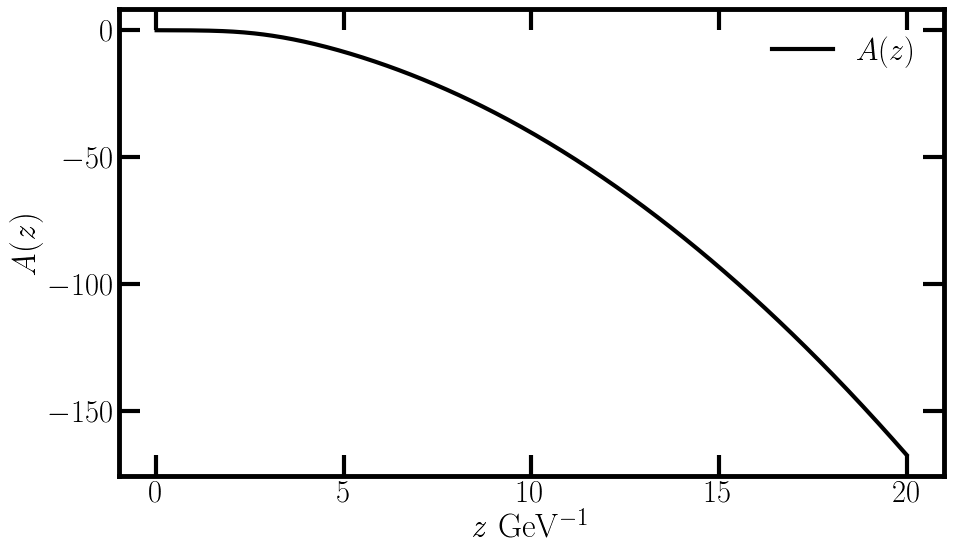

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 第一步：设置全局字体为粗体 
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22, weight='bold')

# 加载模型
model_A.load_state_dict(torch.load('best_A_network.pth'))
model_A.eval()

# 生成z值和计算A(z)
z_values = torch.linspace(0.01, 20, 500).unsqueeze(1).to(device)
with torch.no_grad():
    A_values = model_A(z_values).cpu().numpy()
z_values = z_values.cpu().numpy()

# 创建图形
plt.figure(figsize=(10, 6))

# 绘制曲线
plt.plot(z_values, A_values, color='black', linewidth=3.0, label='$A(z)$')

# 设置坐标轴标签
plt.xlabel(r'$\mathbf{\mathit{z}}$ $\rm GeV^{-1}$', fontsize=24, fontweight='bold')
plt.ylabel(r'$\mathbf{\mathit{A(z)}}$', fontsize=24, fontweight='bold')

# 设置图例
plt.legend(fontsize=18, frameon=False, prop={'weight': 'bold'})

# 设置刻度方向
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# 获取当前轴对象
ax = plt.gca()

# 设置刻度参数
ax.tick_params(axis='both', which='major', 
               direction='in',
               length=15,
               width=3.0,
               bottom=True, top=True, left=True, right=True)

# 设置刻度标签字体为粗体
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
plt.setp(ax.get_xticklabels(), fontweight='bold')
plt.setp(ax.get_yticklabels(), fontweight='bold')

# 设置边框线宽
for spine in ax.spines.values():
    spine.set_linewidth(3.5)

plt.tight_layout()

# 保存为EPS格式
plt.savefig('A_plot.eps', format='eps', dpi=1000)
plt.show()

In [17]:
# draw_aann.py
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

def draw_aann(savepath='aann_diagram.eps'):
    # 统一英文字体
    plt.rcParams.update({
        "text.usetex": False,
        "font.size": 16,
        "font.family": "Times New Roman"
    })

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 5)
    ax.axis('off')

    # 画一个带圆角的框
    def box(x, y, w=1.2, h=2.5, label=None):
        rect = FancyBboxPatch(
            (x, y), w, h,
            boxstyle="round,pad=0.1,rounding_size=6",
            linewidth=1.5, facecolor='none', edgecolor='black'
        )
        ax.add_patch(rect)
        if label:
            ax.text(x + w/2, y + h/2, label,
                    ha='center', va='center', fontsize=12)

    # 箭头函数
    def arrow(x0, x1, ymid):
        ax.annotate('', xy=(x1, ymid), xytext=(x0, ymid),
                    arrowprops=dict(arrowstyle='->', linewidth=1.5))

    # 垂直位置和高度
    y_base = 1.2
    h_box = 2.5

    # 输入
    ax.text(0.4, y_base + h_box/2, r'$z$', fontsize=20, ha='center', va='center')
    arrow(0.55, 1.2, y_base + h_box/2)

    # 隐藏层
    box(1.2, y_base, label="Hidden 1\n(Linear+Tanh)")
    arrow(1.2 + 1.2, 2.8, y_base + h_box/2)

    box(2.8, y_base, label="Hidden 2\n(Linear+Tanh)")
    arrow(2.8 + 1.2, 4.4, y_base + h_box/2)

    box(4.4, y_base, label="Hidden 3\n(Linear+Tanh)")
    arrow(4.4 + 1.2, 6.0, y_base + h_box/2)

    # 输出层
    box(6.0, y_base, label="Output\n(Linear → -exp)")
    arrow(6.0 + 1.2, 7.2, y_base + h_box/2)
    ax.text(7.5, y_base + h_box/2, r'$A(z)$', fontsize=20, ha='center', va='center')

    # 标题
    ax.text(5.0, 4.5, "A_Network", fontsize=22, fontweight='bold', ha='center')

    # 损失函数
    ax.text(5.0, 0.4, r'$\mathcal{L} = \mathcal{L}_{\mathrm{spectrum}} + \mathcal{L}_{\mathrm{entropy}}$',
            fontsize=18, ha='center', va='center')

    # 保存 EPS
    plt.savefig(savepath, format='eps', bbox_inches='tight', dpi=300)
    print(f"Saved EPS to: {savepath}")
    plt.close(fig)

if __name__ == "__main__":
    draw_aann("aann_diagram.eps")


Saved EPS to: aann_diagram.eps
